In [21]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd())) # Include ../SSD in path
import numpy as np
import torch
import matplotlib.pyplot as plt
from vizer.draw import draw_boxes
from tops.config import instantiate, LazyConfig
from ssd import utils
np.random.seed(0)
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet34

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
import torch
import torch.functional as F
import numpy as np
import requests
import torchvision
from PIL import Image
from ssd.modeling.retinanetOutputWrapper import RetinaNetOutputWrapper

In [22]:
config_path = "configs/tdt4265_fpn.py"
# cfg = LazyConfig.load(config_path)

# Get your input
img = read_image("data/tdt4265_2022/images/train/trip007_glos_Video00000_3.png")
# plt.imshow(to_pil_image(img))


In [23]:
# x = normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
x = torch.randn(1, 3, 128, 1024).to("cuda")

model(x)

OrderedDict([('out',
              tensor([[[[ 6.7573,  6.7573,  6.7573,  ...,  6.6188,  6.6188,  6.6188],
                        [ 6.7573,  6.7573,  6.7573,  ...,  6.6188,  6.6188,  6.6188],
                        [ 6.7573,  6.7573,  6.7573,  ...,  6.6188,  6.6188,  6.6188],
                        ...,
                        [ 6.6686,  6.6686,  6.6686,  ...,  6.5760,  6.5760,  6.5760],
                        [ 6.6686,  6.6686,  6.6686,  ...,  6.5760,  6.5760,  6.5760],
                        [ 6.6686,  6.6686,  6.6686,  ...,  6.5760,  6.5760,  6.5760]],
              
                       [[-1.1277, -1.1277, -1.1277,  ..., -1.2449, -1.2449, -1.2449],
                        [-1.1277, -1.1277, -1.1277,  ..., -1.2449, -1.2449, -1.2449],
                        [-1.1277, -1.1277, -1.1277,  ..., -1.2449, -1.2449, -1.2449],
                        ...,
                        [-1.3373, -1.3373, -1.3373,  ..., -1.5080, -1.5080, -1.5080],
                        [-1.3373, -1.3373, -1

In [ ]:
from performance_assessment.save_comparison_images import get_config, get_trained_model, get_dataloader

cfg = get_config(config_path)
model = get_trained_model(cfg)

ImportError: cannot import name 'retinanetOutputWrapper' from 'ssd.modeling.retinanetOutputWrapper' (c:\Users\sebsk\Documents\Git\TDT4265_StarterCode\Project\SSD\ssd\modeling\retinanetOutputWrapper.py)

# pytorch-grad-cam


In [24]:

from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM

In [25]:
wrapped_model = RetinaNetOutputWrapper(model).eval()

In [26]:

input_tensor = normalize(img.float()/255, mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
print(input_tensor.shape)

torch.Size([3, 128, 1024])


In [27]:
if torch.cuda.is_available():
    wrapped_model = wrapped_model.cuda()
    input_tensor = input_tensor.cuda()

In [28]:
print(input_tensor.unsqueeze(0).shape)
output = wrapped_model(input_tensor.unsqueeze(0))

torch.Size([1, 3, 128, 1024])


KeyError: 0

In [ ]:
print(type(output))
print(output)

<class 'list'>
tensor([[0.4333, 0.6592, 0.4585, 0.8492],
        [0.9819, 0.4068, 0.9991, 0.5971],
        [0.4223, 0.6086, 0.4606, 0.9253],
        [0.9268, 0.4963, 0.9552, 0.8980],
        [0.4529, 0.5943, 0.4763, 0.7725],
        [0.4599, 0.6086, 0.4733, 0.7624],
        [0.9856, 0.3817, 1.0032, 0.5373],
        [0.0987, 0.5431, 0.1360, 0.8119],
        [0.9274, 0.4815, 0.9577, 0.8026]], device='cuda:0',
       grad_fn=<IndexBackward0>)


In [ ]:
target_layer = [wrapped_model.model.feature_extractor.fpn._modules]
print(target_layer)

[OrderedDict([('inner_blocks', ModuleList(
  (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
  (4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
)), ('layer_blocks', ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
))])]


In [ ]:
target_layer = [model.feature_extractor.fpn._modules]
# print(target_layer)
print(target_layer[0])

OrderedDict([('inner_blocks', ModuleList(
  (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
  (4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
)), ('layer_blocks', ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
))])


In [ ]:
target_layers = [model.model.backbone.layer4]
targets = [SemanticSegmentationTarget(car_category, car_mask_float)]
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=torch.cuda.is_available()) as cam:
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Image.fromarray(cam_image)

## Test

In [29]:
import numpy as np
image_url = "https://farm1.staticflickr.com/6/9606553_ccc7518589_z.jpg"
image = np.array(Image.open(requests.get(image_url, stream=True).raw))
rgb_img = np.float32(image) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
# Taken from the torchvision tutorial
# https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html
model = deeplabv3_resnet50(pretrained=True, progress=False)
model = model.eval()

if torch.cuda.is_available():
    model = model.cuda()
    input_tensor = input_tensor.cuda()

output = model(input_tensor)
print(type(output), output.keys())

<class 'collections.OrderedDict'> odict_keys(['out', 'aux'])


In [30]:
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model): 
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model
        
    def forward(self, x):
        return self.model(x)["out"]
    
model = SegmentationModelOutputWrapper(model)
output = model(input_tensor)

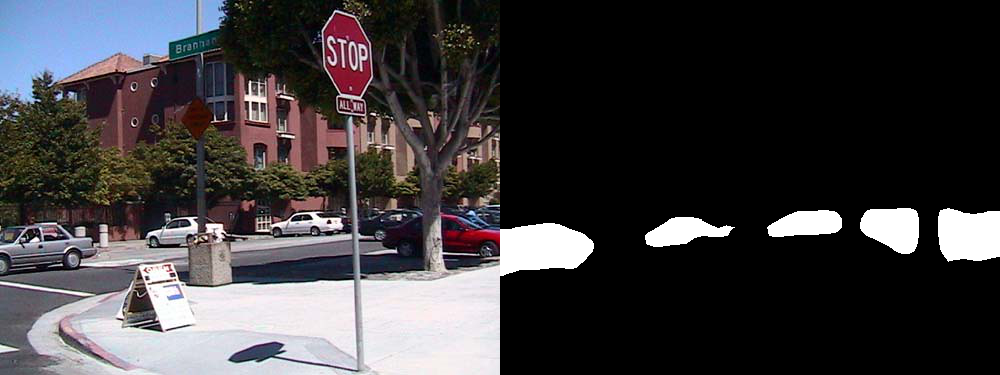

In [31]:
normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

car_category = sem_class_to_idx["car"]
car_mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
car_mask_uint8 = 255 * np.uint8(car_mask == car_category)
car_mask_float = np.float32(car_mask == car_category)

both_images = np.hstack((image, np.repeat(car_mask_uint8[:, :, None], 3, axis=-1)))
Image.fromarray(both_images)

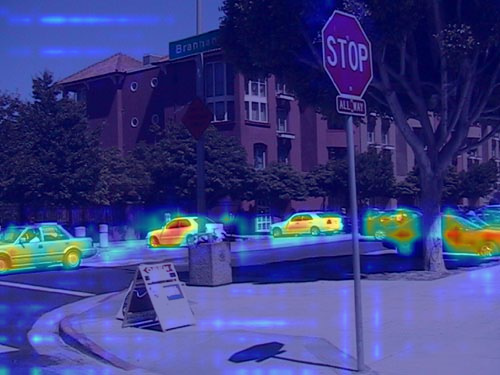

In [32]:
from pytorch_grad_cam import GradCAM

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()

    
target_layers = [model.model.backbone.layer4]
targets = [SemanticSegmentationTarget(car_category, car_mask_float)]
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=torch.cuda.is_available()) as cam:
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Image.fromarray(cam_image)

# torchcam


In [ ]:

from torchcam.methods import SmoothGradCAMpp



model_resnet = resnet34(pretrained=True).eval()
print(model_resnet)
# model = cfg.model
# cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:


# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

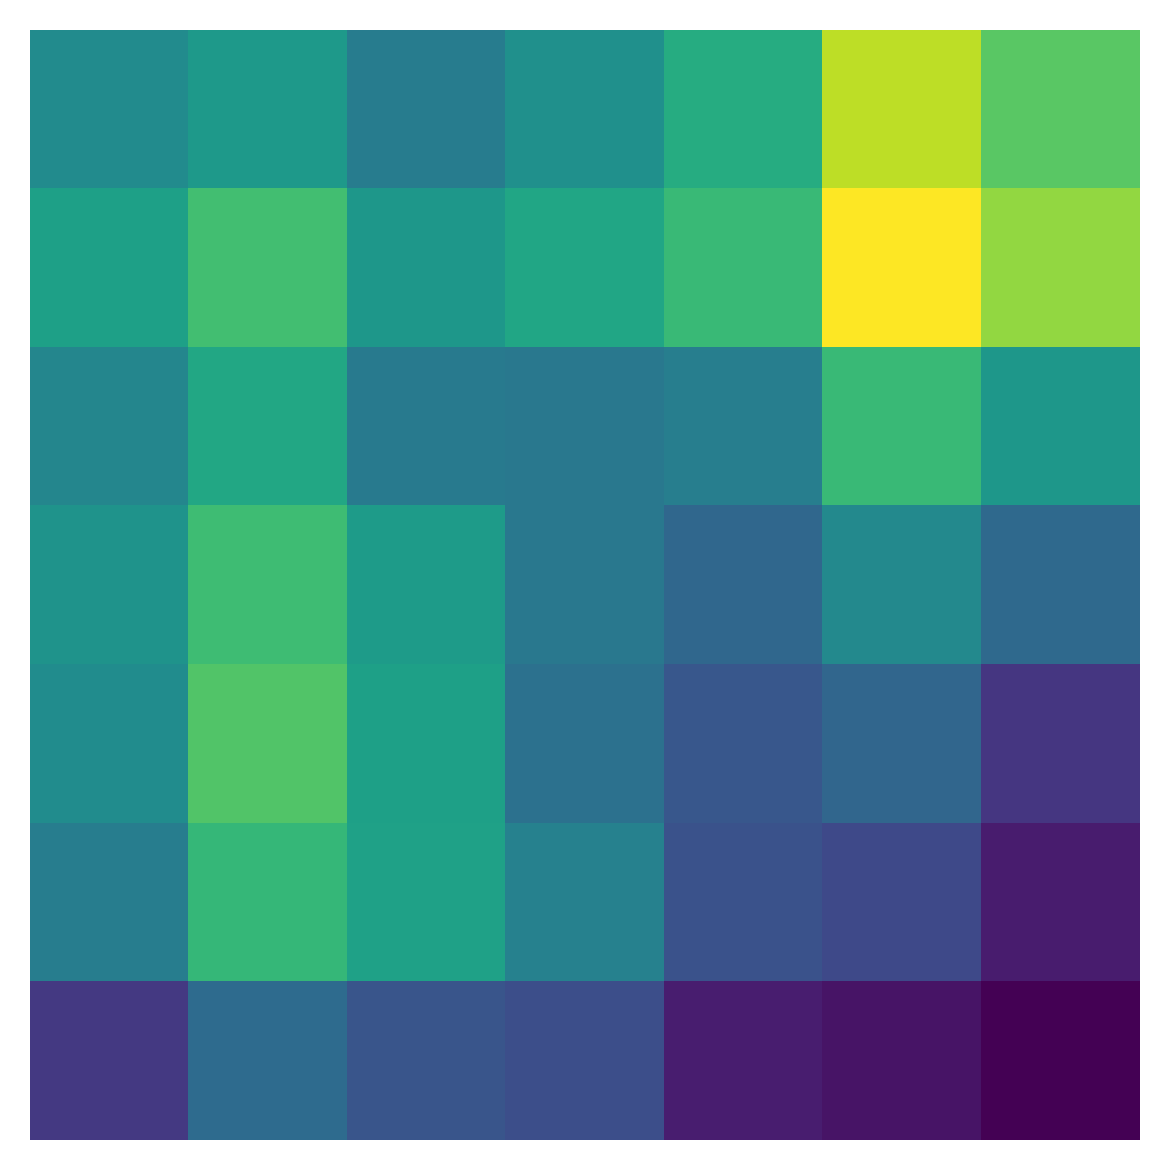

In [ ]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

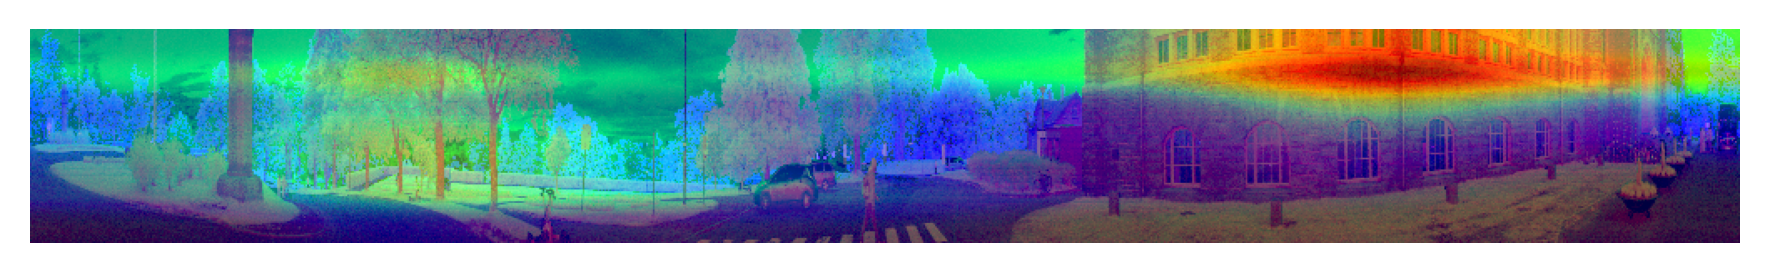

In [ ]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

plt.rc('figure', dpi=300)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()